In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import fftpack
import processing_signals as ps

# plt.figure(figsize=(10, 7))

In [2]:
def signal_1d(a, w, ph, time_counts): # number of oscillations per second
    return a * np.sin(ph + 2 * np.pi * w * time_counts)

Моделируем входной и выходной 2d сигнал на адаптивный фильтр

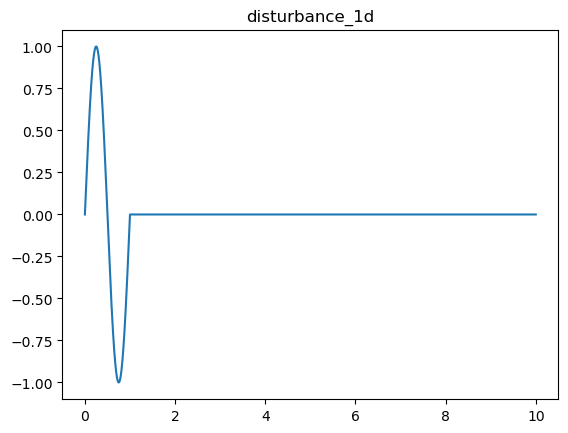

In [3]:
right_bound = 10
number_of_t = 10000
t = np.linspace(0, right_bound, number_of_t, endpoint=False)

disturbance_1d = signal_1d(1, 1, 0, t)
disturbance_1d[int(number_of_t / right_bound):] = 0

# step = 0
# disturbance_1d = np.roll(disturbance_1d, step)

plt.plot(t, disturbance_1d)
plt.title("disturbance_1d")
plt.show()

In [4]:
step = 100
first_input_2d = disturbance_1d

number_of_x = 84
for i in range(1, number_of_x):
    first_input_2d = np.vstack([first_input_2d, np.roll(disturbance_1d, step * i)])
    # plt.plot(t, disturbance_1d)
    # plt.title("disturbance_1d")
    # plt.show()

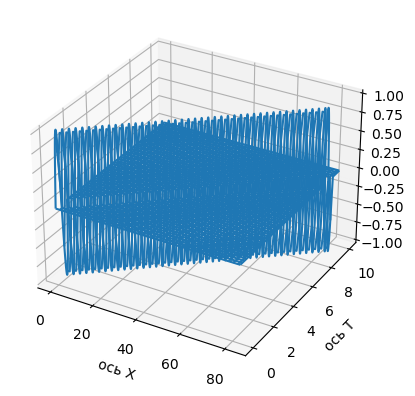

In [5]:
xgrid, tgrid = np.meshgrid(np.arange(number_of_x), t)


ax = plt.axes(projection='3d')
ax.plot_wireframe(xgrid, tgrid, first_input_2d.T)
# ax.plot(tgrid, xgrid, tempU.reshape((len(np.unique(tempT)), len(np.unique(tempX)))))
plt.xlabel("ось X")
plt.ylabel("ось T")
plt.show()

Промоделируем второй входной сигнал такими весами

In [6]:
# processing_weights = np.array([0.1, 0.3, 0.5])
processing_weights_2d = (np.ones((1, number_of_x)) * [[1 / (i + 1) for i in range(number_of_x)]]).reshape((1, number_of_x))
print(processing_weights_2d)

[[1.         0.5        0.33333333 0.25       0.2        0.16666667
  0.14285714 0.125      0.11111111 0.1        0.09090909 0.08333333
  0.07692308 0.07142857 0.06666667 0.0625     0.05882353 0.05555556
  0.05263158 0.05       0.04761905 0.04545455 0.04347826 0.04166667
  0.04       0.03846154 0.03703704 0.03571429 0.03448276 0.03333333
  0.03225806 0.03125    0.03030303 0.02941176 0.02857143 0.02777778
  0.02702703 0.02631579 0.02564103 0.025      0.02439024 0.02380952
  0.02325581 0.02272727 0.02222222 0.02173913 0.0212766  0.02083333
  0.02040816 0.02       0.01960784 0.01923077 0.01886792 0.01851852
  0.01818182 0.01785714 0.01754386 0.01724138 0.01694915 0.01666667
  0.01639344 0.01612903 0.01587302 0.015625   0.01538462 0.01515152
  0.01492537 0.01470588 0.01449275 0.01428571 0.01408451 0.01388889
  0.01369863 0.01351351 0.01333333 0.01315789 0.01298701 0.01282051
  0.01265823 0.0125     0.01234568 0.01219512 0.01204819 0.01190476]]


In [7]:
second_input_2d = ps.processing_of_signal(first_input_2d, processing_weights_2d)

(84, 10000) (1, 84)


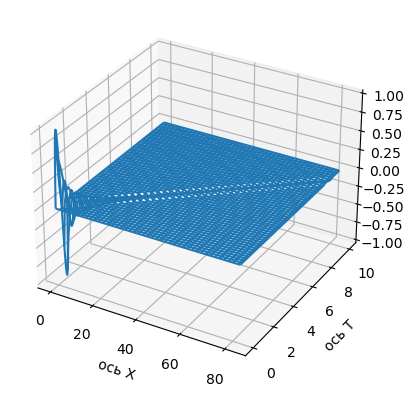

In [8]:
ax = plt.axes(projection='3d')
ax.plot_wireframe(xgrid, tgrid, second_input_2d.T)
# ax.plot(tgrid, xgrid, tempU.reshape((len(np.unique(tempT)), len(np.unique(tempX)))))
plt.xlabel("ось X")
plt.ylabel("ось T")
plt.show()

Подбираем веса свертки

In [9]:
number_of_weights_2d = 1

Можно закомментировать, тк ищутся долго

In [10]:
# approx_weights_2d = ps.fitting_of_weights(first_input_2d, second_input_2d, number_of_weights_2d, 0.9, 1)
# print(approx_weights_2d)

# Оффтоп - Реальный сигнал ============================================================

In [11]:
model = np.load("MODEL.NPY")
model_agc = np.load("MODEL_AGC.NPY")
gather = np.load("GATHER.NPY")

print(model.shape, model_agc.shape, gather.shape)

(96, 2001) (96, 2001) (96, 2001)


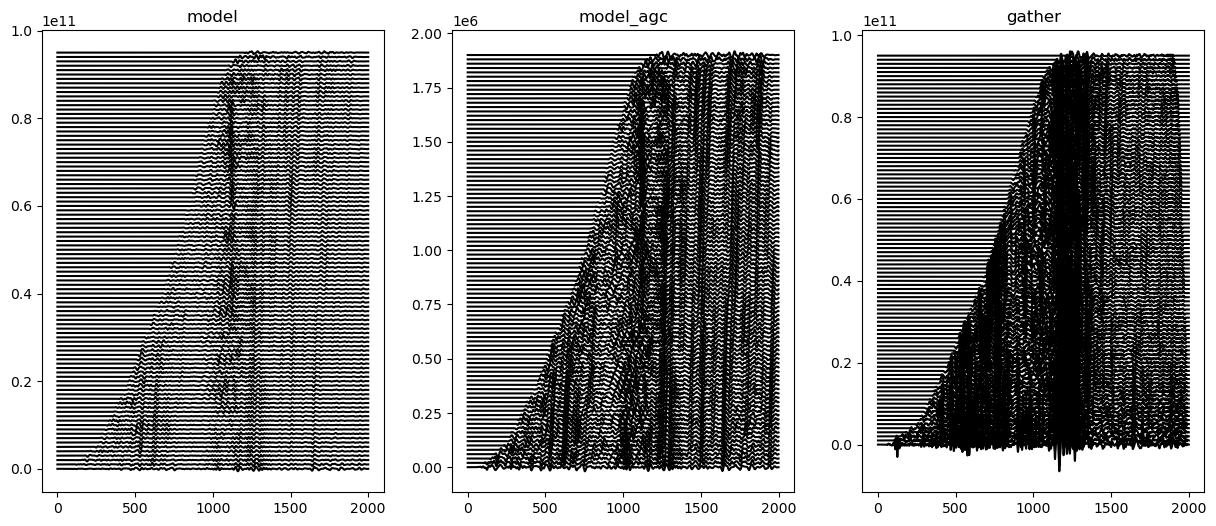

In [12]:
plt.figure(figsize=(15, 6))


shift = 1e+9
plt.subplot(1, 3, 1)
plt.title("model")
for i in range(96):
    plt.plot(shift * i + model[i], color='black')

shift_agc = 1e+5 / 5
plt.subplot(1, 3, 2)
plt.title("model_agc")
for i in range(96):
    plt.plot(shift_agc * i + model_agc[i], color='black')


plt.subplot(1, 3, 3)
plt.title("gather")
for i in range(96):
    plt.plot(shift * i + gather[i], color='black')

plt.show()

Для примера возьмем нулевую трассу

In [74]:
approx_real_weights_1d = ps.fitting_of_weights(model_agc[0], gather[0], 2, 0.9)
print(approx_real_weights_1d, approx_real_weights_1d.shape)

[ 3582356.19902967 -7992800.63759493  3571310.87915286] (3,)


In [76]:
approx_real_signal_1d = ps.processing_of_signal(model_agc[0], approx_real_weights_1d)

# print(f"MSE = {ps.MSE(approx_real_signal_1d, gather[0]):.1e}")
print(f"MSE = {ps.MSE(approx_real_signal_1d, model[0]):.1e}")

(2001,) (3,)
MSE = 3.8e+19


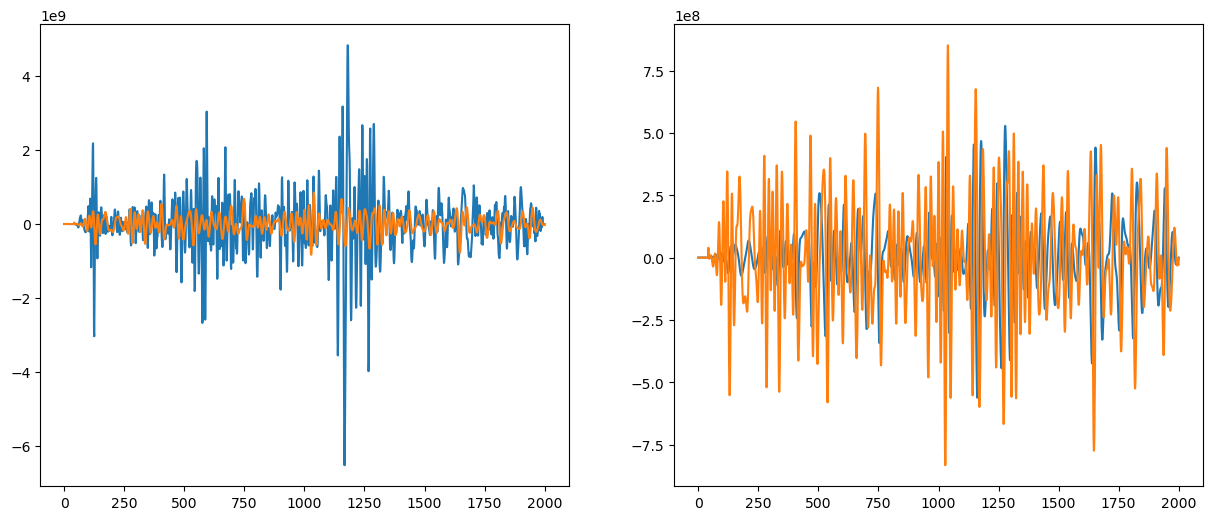

In [72]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(gather[0])
plt.plot(approx_real_signal_1d)

plt.subplot(1, 2, 2)
plt.plot(model[0])
plt.plot(approx_real_signal_1d)


plt.show()

# ============================================================

Входной и выходной 1d сигнал на адаптивный фильтр

In [34]:
right_bound = 10
number_of_point = 10000
# number_of_point = first_input_1d.size
t = np.linspace(0, right_bound, number_of_point, endpoint=False)

In [35]:
initial_weights_1d = np.array([0.1, 0.3, 0.5])

In [36]:
# first_input_1d = 1 / (1 + t) * signal_1d(0.5, 10, 0, t)
first_input_1d = signal_1d(0.5, 10, 0, t)

second_input_1d = signal_1d(1, 1, 0, t) + ps.processing_of_signal(first_input_1d, initial_weights_1d)
# second_input_1d = ps.processing_of_signal(first_input_1d, initial_weights_1d)

(10000,) (3,)


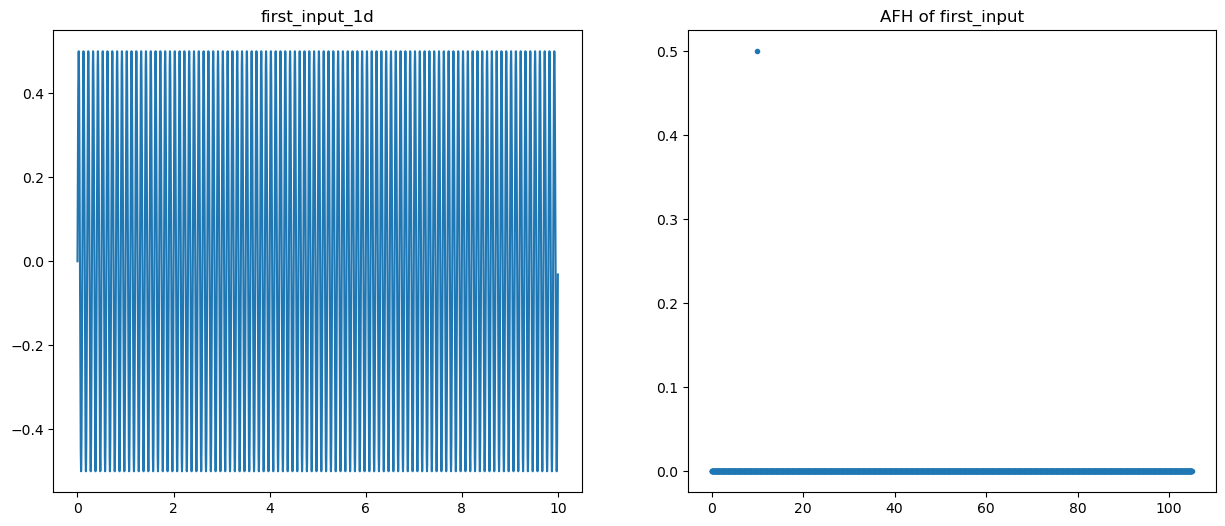

In [37]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(t, first_input_1d)
plt.title("first_input_1d")
# plt.show()

freq_bound = 2100

x = fftpack.rfftfreq(first_input_1d.size, right_bound / number_of_point)
y = 2 * np.abs(fftpack.rfft(first_input_1d)) / first_input_1d.size

plt.subplot(1, 2, 2)
plt.plot(x[:freq_bound], y[:freq_bound], '.')
plt.title("AFH of first_input")
plt.show()

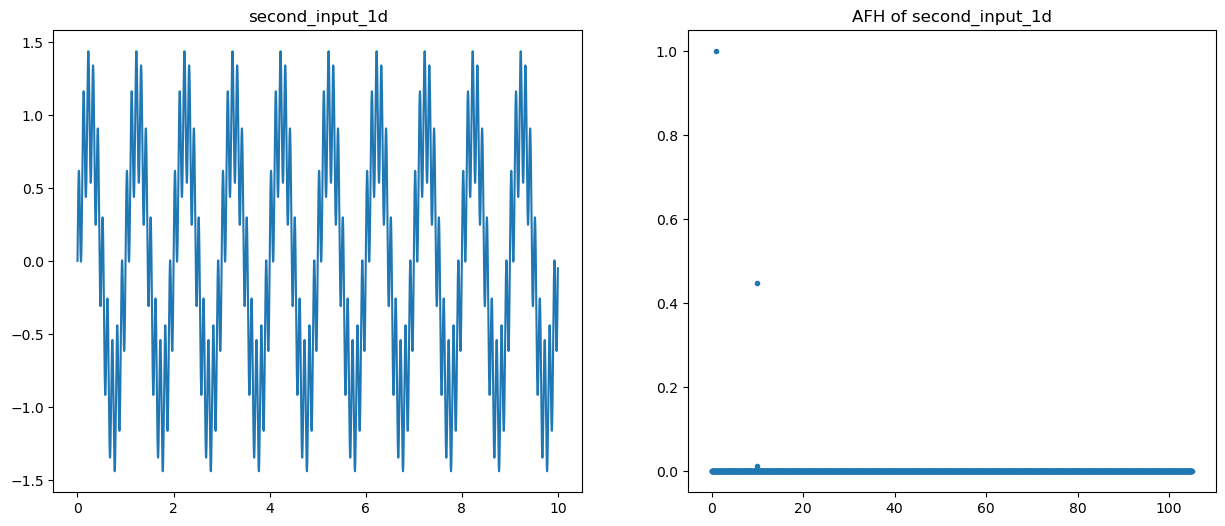

In [38]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(t, second_input_1d)
plt.title("second_input_1d")
# plt.show()

freq_bound = 2100

x = fftpack.rfftfreq(second_input_1d.size, right_bound / number_of_point)
y = 2 * np.abs(fftpack.rfft(second_input_1d)) / second_input_1d.size

plt.subplot(1, 2, 2)
plt.plot(x[:freq_bound], y[:freq_bound], '.')
plt.title("AFH of second_input_1d")
plt.show()

Определим длину вектора высовых коэффициентов свертки, которыми мы будем апроксимировать АЧХ исходной системы

In [39]:
number_of_weights = 3

Выведим полученные коэффициенты свертки

In [40]:
approx_weights_1d = ps.fitting_of_weights(first_input_1d, second_input_1d, number_of_weights, 0.9, 1)
print(approx_weights_1d)

[0.05031573 0.36466619 0.68152402]


Построим сигнал по найденным весам

In [41]:
approx_signal_1d = ps.processing_of_signal(first_input_1d, approx_weights_1d)

(10000,) (3,)


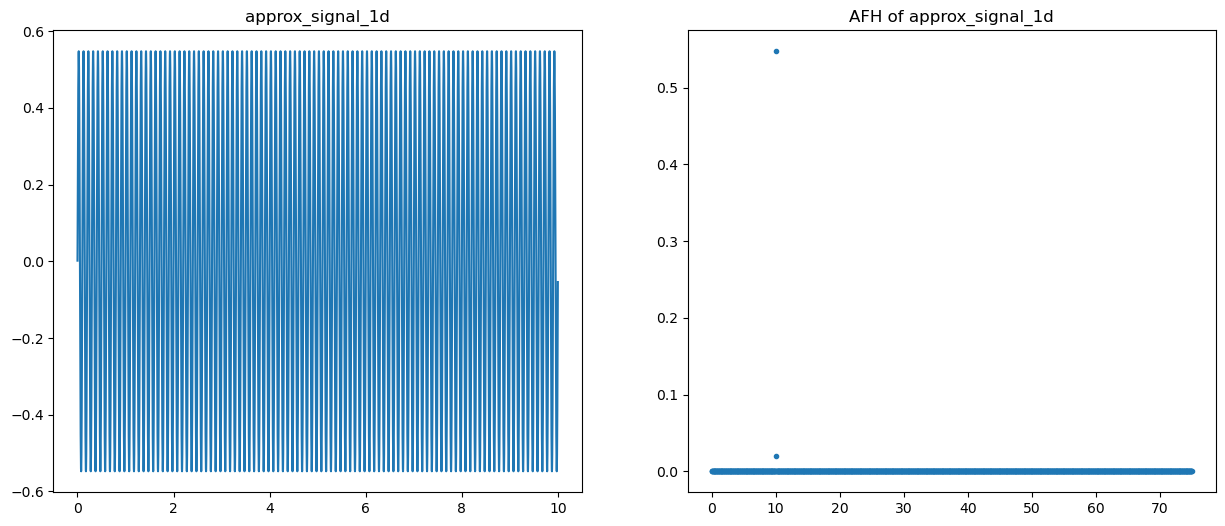

In [42]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(t, approx_signal_1d)
plt.title("approx_signal_1d")
# plt.show()

freq_bound = 1500

x = fftpack.rfftfreq(approx_signal_1d.size, right_bound / number_of_point)
y = 2 * np.abs(fftpack.rfft(approx_signal_1d)) / approx_signal_1d.size

plt.subplot(1, 2, 2)
plt.plot(x[:freq_bound], y[:freq_bound], '.')
plt.title("AFH of approx_signal_1d")
plt.show()

# Рассмотрим АЧХ исходной и полученной передаточной функции

In [43]:
# all_spectrum = np.zeros(t.size)
# all_spectrum[int(t.size / 2)] = 1

all_spectrum = np.zeros(100)
all_spectrum[50] = 1

In [44]:
initial_weights_signal_1d = ps.processing_of_signal(all_spectrum, initial_weights_1d)

(100,) (3,)


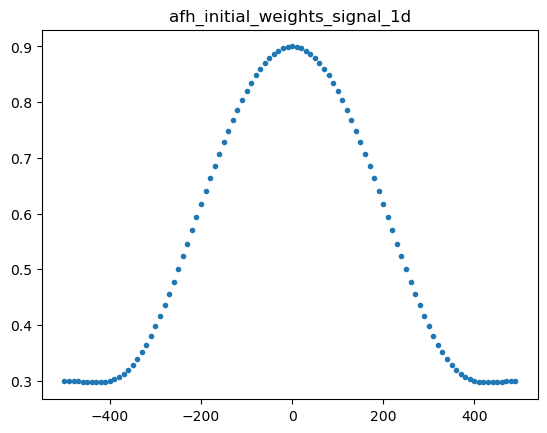

In [45]:
# plt.plot(np.arange(100), initial_weights_signal_1d, ".")
# plt.title("initial_weights_signal_1d")
# plt.show()

freq_bound = 1500

initial_fx = fftpack.fftfreq(initial_weights_signal_1d.size, right_bound / number_of_point)
initial_fy = np.abs(fftpack.fft(initial_weights_signal_1d))

plt.plot(initial_fx[:freq_bound], initial_fy[:freq_bound], ".")
plt.title("afh_initial_weights_signal_1d")
plt.show()

In [46]:
approx_weights_signal_1d = ps.processing_of_signal(all_spectrum, approx_weights_1d)

(100,) (3,)


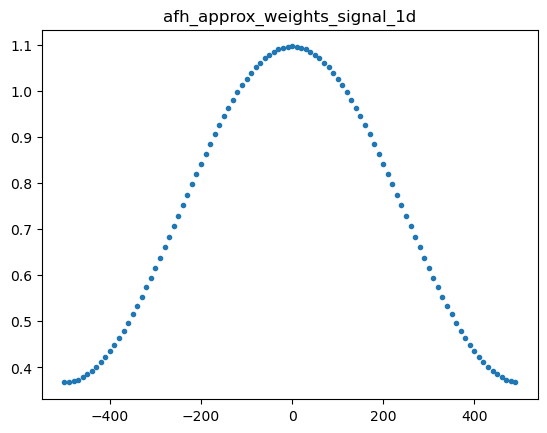

In [47]:
# plt.plot(np.arange(100), approx_weights_signal_1d, ".")
# plt.title("approx_weights_signal_1d")
# plt.show()

freq_bound = 1500

approx_fx = fftpack.fftfreq(approx_weights_signal_1d.size, right_bound / number_of_point)
approx_fy = np.abs(fftpack.fft(approx_weights_signal_1d))

plt.plot(approx_fx[:freq_bound], approx_fy[:freq_bound], ".")
plt.title("afh_approx_weights_signal_1d")
plt.show()

Наложим их АЧХ друг на друга

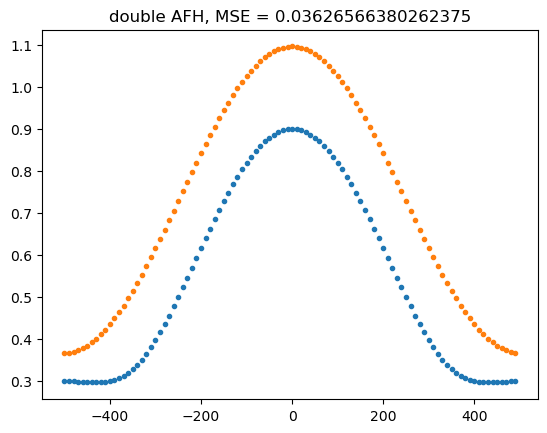

In [48]:
plt.plot(initial_fx, initial_fy, ".")
plt.plot(approx_fx, approx_fy, ".")
plt.title(f"double AFH, MSE = {ps.MSE(approx_fy, initial_fy)}")

plt.show()